# Import Data

In [6]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.metrics import make_scorer, cohen_kappa_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.feature_selection import RFECV
from scipy.stats import ttest_ind, ttest_1samp

In [7]:
# read data
df_outcomes = pd.read_csv("../dat/nsds_II_outcomes_level1_AAK.csv")
df_predictors = pd.read_csv("../dat/nsds_II_predictors_level1.csv")

In [16]:
# read data for flirting
rating_m1 = pd.read_excel("../dat/Ratings_m1.xlsx")
rating_m2 = pd.read_excel("../dat/Ratings_m2.xlsx")
rating_w1 = pd.read_excel("../dat/Ratings_w1.xlsx")
rating_w2 = pd.read_excel("../dat/Ratings_w2.xlsx")
matching = pd.read_excel("../dat/matching.xlsx")

ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.

# Clean Data

## Outcomes

In [10]:
# drop unnecessary columns in outcome dataset

df_outcomes = df_outcomes.drop(["id", "gender_of_id", "st_raw", "lt_raw", "Unnamed: 0"], axis = 1)

print(df_outcomes.describe())
print("\n")


# create new dataset with calculated partner score as dependent variable

mean_gr = df_outcomes["general_raw"].mean()


outcomes = df_outcomes.groupby("partnerid").mean() - mean_gr
outcomes.columns = ["partner_score"]
outcomes = outcomes.drop(219)


# convert outcome datasets into 1D-arrays
outcomes = np.array(outcomes).ravel()


         partnerid  general_raw
count  2171.000000  2171.000000
mean    181.893137     4.935130
std     121.011580     1.901438
min       7.000000     1.000000
25%      69.000000     3.666667
50%     171.000000     5.000000
75%     281.000000     6.333333
max     433.000000     9.000000




## Predictors

### Self-Reports

In [11]:
# delete _par-variables, fill NA-values in predictors dataset

imputer = SimpleImputer(strategy = "mean", missing_values = np.nan)

for column in df_predictors:
    if column != "gender_id":
        imputer = imputer.fit(df_predictors[[column]])
        df_predictors[column] = imputer.transform(df_predictors[[column]])
    if column.endswith("_par"):
        df_predictors = df_predictors.drop(columns = column)

In [12]:
# new dataset with calculated mean for att_rating_act

df_predictors = df_predictors.drop(["partnerid", "gender_id"], axis = 1)
predictors = df_predictors.groupby("id").mean()

### Flirting

Create a new predictors dataset with self-reports AND flirting ratings:

In [13]:
# interrater correlation

print("rating_m1")
print("F_gen:", np.corrcoef(rating_m1.loc[rating_m1["Rater"] == "R_m1_1"]["F_gen"], rating_m1.loc[rating_m1["Rater"] == "R_m1_2"]["F_gen"]).ravel()[1])
print("F_ag:", np.corrcoef(rating_m1.loc[rating_m1["Rater"] == "R_m1_1"]["F_ag"], rating_m1.loc[rating_m1["Rater"] == "R_m1_2"]["F_ag"]).ravel()[1])
print("F_com:", np.corrcoef(rating_m1.loc[rating_m1["Rater"] == "R_m1_1"]["F_com"], rating_m1.loc[rating_m1["Rater"] == "R_m1_2"]["F_com"]).ravel()[1])
print("\n")
print("rating_m2")
print("F_gen:", np.corrcoef(rating_m2.loc[rating_m2["Rater"] == "R_m2_1"]["F_gen"], rating_m2.loc[rating_m2["Rater"] == "R_m2_2"]["F_gen"]).ravel()[1])
print("F_ag:", np.corrcoef(rating_m2.loc[rating_m2["Rater"] == "R_m2_1"]["F_ag"], rating_m2.loc[rating_m2["Rater"] == "R_m2_2"]["F_ag"]).ravel()[1])
print("F_com:", np.corrcoef(rating_m2.loc[rating_m2["Rater"] == "R_m2_1"]["F_com"], rating_m2.loc[rating_m2["Rater"] == "R_m2_2"]["F_com"]).ravel()[1])
print("\n")
print("rating_w1")
print("F_gen:", np.corrcoef(rating_w1.loc[rating_w1["Rater"] == "R_w1_1"]["F_gen"], rating_w1.loc[rating_w1["Rater"] == "R_w1_2"]["F_gen"]).ravel()[1])
print("F_ag:", np.corrcoef(rating_w1.loc[rating_w1["Rater"] == "R_w1_1"]["F_ag"], rating_w1.loc[rating_w1["Rater"] == "R_w1_2"]["F_ag"]).ravel()[1])
print("F_com:", np.corrcoef(rating_w1.loc[rating_w1["Rater"] == "R_w1_1"]["F_com"], rating_w1.loc[rating_w1["Rater"] == "R_w1_2"]["F_com"]).ravel()[1])
print("\n")
print("rating_w2")
print("F_gen:", np.corrcoef(rating_w2.loc[rating_w2["Rater"] == "R_w2_1"]["F_gen"], rating_w2.loc[rating_w2["Rater"] == "R_w2_2"]["F_gen"]).ravel()[1])
print("F_ag:", np.corrcoef(rating_w2.loc[rating_w2["Rater"] == "R_w2_1"]["F_ag"], rating_w2.loc[rating_w2["Rater"] == "R_w2_2"]["F_ag"]).ravel()[1])
print("F_com:", np.corrcoef(rating_w2.loc[rating_w2["Rater"] == "R_w2_1"]["F_com"], rating_w2.loc[rating_w2["Rater"] == "R_w2_2"]["F_com"]).ravel()[1])


rating_m1


NameError: name 'rating_m1' is not defined

In [ ]:
# devide matching into female & male dataframe

matching_wom = matching[matching["gender"] == "f"]
matching_wom = matching_wom.drop(["code", "revcode", "gender"], axis = 1)

matching_men = matching[matching["gender"] == "m"]
matching_men = matching_men.drop(["code", "revcode", "gender"], axis = 1)

In [ ]:
# create one dataframe each for female & male participants

flirting_rat_wom = pd.concat([rating_m1, rating_m2], axis = 0)
flirting_rat_men = pd.concat([rating_w1, rating_w2], axis = 0)

In [ ]:
# clean dataframes, create rater-means

flirting_rat_wom = flirting_rat_wom.drop(["Rater"], axis = 1)
flirting_rat_wom = flirting_rat_wom.rename(columns = {"Videos": "datecode"})
list_wom = list(x[:-2] for x in flirting_rat_wom["datecode"])
list_wom = list(x.replace("_", "") for x in list_wom)
flirting_rat_wom["datecode"] = list_wom
flirting_rat_wom = flirting_rat_wom.groupby("datecode").mean()

flirting_rat_men = flirting_rat_men.drop(["Rater"], axis = 1)
flirting_rat_men = flirting_rat_men.rename(columns = {"Videos": "datecode"})
list_men = list(x[:-2] for x in flirting_rat_men["datecode"])
list_men = list(x.replace("_", "") for x in list_men)
flirting_rat_men["datecode"] = list_men
flirting_rat_men = flirting_rat_men.groupby("datecode").mean()

In [ ]:
# match id and datecode

flirt_wom = pd.merge(flirting_rat_wom, matching_wom, on = ["datecode"])
flirt_wom = flirt_wom.drop(["datecode"], axis = 1)

flirt_men = pd.merge(flirting_rat_men, matching_men, on = ["datecode"])
flirt_men = flirt_men.drop(["datecode"], axis = 1)

In [ ]:
# final flirting dataset

flirting = pd.concat([flirt_wom, flirt_men], axis = 0)
flirting = flirting.rename(columns = {"user_id": "id", "partner_id": "partnerid"})


# add to predictors

df_predictors_fl = df_predictors.merge(flirting, how = "left", on = ["id", "partnerid"])

In [ ]:
# delete _par-variables, fill NA-values in predictors dataset

imputer = SimpleImputer(strategy = "mean", missing_values = np.nan)

for column in df_predictors_fl:
    if column != "gender_id":
        imputer = imputer.fit(df_predictors_fl[[column]])
        df_predictors_fl[column] = imputer.transform(df_predictors_fl[[column]])
    if column.endswith("_par"):
        df_predictors_fl = df_predictors_fl.drop(columns = column)

In [ ]:
# new dataset with calculated mean for att_rating_act & flirting

df_predictors_fl = df_predictors_fl.drop(["partnerid", "gender_id"], axis = 1)
predictors_fl = df_predictors_fl.groupby("id").mean()

In [ ]:
# descriptive statistics

descript_stat = predictors_fl.describe()
descript_stat = descript_stat.transpose()
descript_stat["mean"] = list(round(x, 2) for x in descript_stat["mean"])
descript_stat["std"] = list(round(x, 2) for x in descript_stat["std"])
descript_stat.to_excel("descript_stat.xlsx")

# Research question 1a

How well can partner effects be predicted using a cross-validated machine learning model that is trained on self-reports?

## RQ1a: Random Forest

In [6]:
# define score function: correlation (between the predicted and true value)

def correlation(X, y):
    x = np.corrcoef(X, y).ravel()
    return x[1]

corr_score = make_scorer(score_func = correlation, greater_is_better = True)

In [7]:
# create dictionary with parameters for hyperparameter tuning

rf_params = {
    "n_estimators": [25, 50, 100, 200],
    "max_depth": [1, 10, None],
    "max_features": ["sqrt", "log2", 0.1],
    "min_samples_leaf": [1, 2, 5, 10]
}

In [8]:
# Nested cross-validation with hyperparameter tuning for Random Forest

# inner cv: find the best hyperparameters
rf = GridSearchCV(estimator = RandomForestRegressor(random_state = 42), param_grid = rf_params, 
                  cv = 5, refit = True, scoring = corr_score)

rf.fit(predictors, outcomes)


# feature selection

selector = RFECV(rf.best_estimator_, cv = 5)
selector = selector.fit(predictors, outcomes)

selected_pred = predictors
selected_pred = selected_pred.loc[:, selected_pred.columns.intersection(np.array(predictors.columns)[selector.support_])]


# outer cv: generalization error on the outer splits
rf_scores = cross_val_score(rf.best_estimator_, selected_pred, outcomes, cv = 5, 
                            scoring = corr_score)

rf.fit(selected_pred, outcomes)


# mean correlation across each of outer_cv's folds
rf_average_score = np.mean(rf_scores)
error_summary = "Model: Random Forest\nCorrelations (5 outer folds): {scores}.\nAverage correlation: {avg}"
print(error_summary.format(scores = rf_scores, 
                           avg = rf_average_score))

Model: Random Forest
Correlations (5 outer folds): [0.43121164 0.33697396 0.2779522  0.51904809 0.43702362].
Average correlation: 0.4004419038180826


In [9]:
rf_scores = list(round(x, 2) for x in rf_scores)
rf_scores

[0.43, 0.34, 0.28, 0.52, 0.44]

In [10]:
# number of included Features

len(selected_pred.columns)

20

In [11]:
# get best parameters

best_params_rf = rf.best_params_
best_params_rf

{'max_depth': 10,
 'max_features': 0.1,
 'min_samples_leaf': 5,
 'n_estimators': 200}

# Research question 1b

How well can partner effects be predicted using a cross-validated machine learning model that is trained on self-reports AND flirting behavior?

### RQ1b: Random Forest with Flirting

Calculate the same Random Forest model again, but on an extended set of predictors (self-reports + flirting ratings)

In [22]:
# create dictionary with parameters for hyperparameter tuning

rf_params = {
    "n_estimators": [25, 50, 100, 200],
    "max_depth": [1, 10, None],
    "max_features": ["sqrt", "log2", 0.1],
    "min_samples_leaf": [1, 2, 5, 10]
}

In [23]:
# Nested cross-validation with hyperparameter tuning for Random Forest

# inner cv: find the best hyperparameters
rf_fl = GridSearchCV(estimator = RandomForestRegressor(random_state = 42), param_grid = rf_params, 
                  cv = 5, refit = True, scoring = corr_score)

rf_fl.fit(predictors_fl, outcomes)


# feature selection

selector_fl = RFECV(rf_fl.best_estimator_, cv = 5)
selector_fl = selector_fl.fit(predictors_fl, outcomes)

selected_pred_fl = predictors_fl
selected_pred_fl = selected_pred_fl.loc[:, selected_pred_fl.columns.intersection(np.array(predictors_fl.columns)[selector_fl.support_])]


# outer cv: generalization error on the outer splits
rf_scores_fl = cross_val_score(rf_fl.best_estimator_, selected_pred_fl, outcomes, cv = 5, 
                            scoring = corr_score)

rf_fl.fit(selected_pred_fl, outcomes)


# mean correlation across each of outer_cv's folds
rf_average_score_fl = np.mean(rf_scores_fl)
error_summary = "Model: Random Forest\nCorrelations (5 outer folds): {scores}.\nAverage correlation: {avg}"
print(error_summary.format(scores = rf_scores_fl, 
                           avg = rf_average_score_fl))

Model: Random Forest
Correlations (5 outer folds): [0.41088367 0.46226581 0.48945083 0.64444092 0.45780416].
Average correlation: 0.4929690763343918


In [24]:
rf_scores_fl = list(round(x, 2) for x in rf_scores_fl)
rf_scores_fl

[0.41, 0.46, 0.49, 0.64, 0.46]

In [25]:
# number of included Features

len(selected_pred_fl.columns)

12

In [26]:
# get best parameters

best_params_rf_fl = rf_fl.best_params_
best_params_rf_fl

{'max_depth': None,
 'max_features': 0.1,
 'min_samples_leaf': 1,
 'n_estimators': 25}

## RQ1b: t-Test 
### Comparison of the Random Forest models: Flirting vs. no flirting

Does the Random Forest model with flirting behavior as additional predictors significantly perform better/worse than the model without flirting ratings?

#### Assumptions

In [27]:
# Testing the t-Test assumptions

# Shapiro-Wilk test for testing if the data was drawn from a normal distribution

print("Random Forest without flirting:")
print(stats.shapiro(rf_scores))
print("\nRandom Forest with flirting:")    
print(stats.shapiro(rf_scores_fl))
print("\n")    


# Levene-test for testing if the variances are equal

print("Homogeneity of variances?")
print(stats.levene(rf_scores_fl, rf_scores))

Random Forest without flirting:
ShapiroResult(statistic=0.966947078704834, pvalue=0.8553216457366943)

Random Forest with flirting:
ShapiroResult(statistic=0.8355451822280884, pvalue=0.1529797613620758)


Homogeneity of variances?
LeveneResult(statistic=0.13487881981032643, pvalue=0.7229514740359115)


#### Comparison (flirting vs. no flirting)

In [28]:
# t-Test to compare the model performances

p_value_rf_fl = ttest_ind(rf_scores_fl, rf_scores)
print(p_value_rf_fl)
print("\n")    


if p_value_rf_fl[1] < 0.05:
    print("The Random Forest models with and without flirting ratings as predictors ARE significantly different in their performance: p-value =", round(p_value_rf_fl[1], 3))
else:
    print("The Random Forest models with and without flirting ratings as predictors are NOT significantly different in their performance: p-value =", round(p_value_rf_fl[1], 3))
    
print("\n")    
print("Random Forest Model without flirting \nAverage correlation: ", round(rf_average_score, 2), 
      "\nStandard deviation: ", round(np.std(rf_scores), 2))
print("\n")
print("Random Forest Model with flirting \nAverage correlation: ", round(rf_average_score_fl, 2), 
      "\nStandard deviation: ", round(np.std(rf_scores_fl), 2))
print("\n")

Ttest_indResult(statistic=1.571947490844377, pvalue=0.15460625711999726)


The Random Forest models with and without flirting ratings as predictors are NOT significantly different in their performance: p-value = 0.155


Random Forest Model without flirting 
Average correlation:  0.4 
Standard deviation:  0.08


Random Forest Model with flirting 
Average correlation:  0.49 
Standard deviation:  0.08




# Research question 2

Do linear or nonlinear machine learning models provide more accurate predictions of partner effects?

## RQ2: Lasso Regression

Calculate the Lasso Regression model, trained on the extended set of predictors (self-reports + flirting ratings)

In [29]:
# create dictionary with parameters for hyperparameter tuning

lasso_params = {"alpha": [0.001, 0.01, 0.1, 1, 10]}

In [30]:
# Nested cross-validation with hyperparameter tuning for Lasso Regression

np.seterr(invalid = "ignore")

# inner cv: find the best hyperparameters
lasso_fl = GridSearchCV(estimator = Lasso(normalize = True), param_grid = lasso_params, 
                                                cv = 5, refit = True, scoring = corr_score)

lasso_fl.fit(predictors_fl, outcomes)

# outer cv: generalization error on the outer splits
lasso_scores_fl = cross_val_score(lasso_fl.best_estimator_, predictors_fl, outcomes, cv = 5, 
                                     scoring = corr_score)

# mean correlation across each of outer_cv's folds
lasso_average_score_fl = np.mean(lasso_scores_fl)
error_summary = "Model: Lasso\nCorrelations (5 outer folds): {scores}.\nAverage correlation: {avg}"
print(error_summary.format(scores = lasso_scores_fl, 
                           avg = lasso_average_score_fl))

Model: Lasso
Correlations (5 outer folds): [0.37451007 0.29592872 0.26399723 0.65397084 0.37507988].
Average correlation: 0.39269734747834384


/Users/kim/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:922: UserWarning: One or more of the test scores are non-finite: [0.29117254 0.39269735        nan        nan        nan]
  warnings.warn(


In [31]:
lasso_scores_fl = list(round(x, 2) for x in lasso_scores_fl)
lasso_scores_fl

[0.37, 0.3, 0.26, 0.65, 0.38]

In [32]:
# number of included Features

lasso_Series_fl = pd.Series(lasso_fl.best_estimator_.coef_.squeeze().tolist(), index = predictors_fl.columns)
lasso_Series_fl = lasso_Series_fl.sort_values(ascending = True)
lasso_Series_fl = lasso_Series_fl[lasso_Series_fl != 0]
len(lasso_Series_fl)

10

In [33]:
# get best parameters

best_params_lasso_fl = lasso_fl.best_params_
best_params_lasso_fl

{'alpha': 0.01}

## RQ2: Comparison of the models

### RQ2: t-Test 
#### Assumptions

In [34]:
# Testing the t-Test assumptions

# Levene-test for testing if the variances are equal

print("\nLasso Regression:")    
print(stats.shapiro(lasso_scores_fl))
print("\n")   

print("Homogeneity of variances?")
print(stats.levene(rf_scores_fl, lasso_scores_fl))


Lasso Regression:
ShapiroResult(statistic=0.8333944082260132, pvalue=0.1474747359752655)


Homogeneity of variances?
LeveneResult(statistic=0.4793478260869563, pvalue=0.5083119604751156)


#### Are the performances of both models (RF & Lasso) different from 0?

In [35]:
# Are the correlation significantly different from 0?
# t-Test

t_test_rf = ttest_1samp(rf_scores_fl, popmean = 0)

t_test_lasso = ttest_1samp(lasso_scores_fl, popmean = 0)

if t_test_rf[1] < 0.05:
    print("Random Forest correlations ARE significantly different from 0: p-value =", round(t_test_rf[1], 4))
else: 
    print("Random Forest correlations are NOT significantly different from 0: p-value =", round(t_test_rf[1], 4))

print(t_test_rf)
print("\n")

if t_test_lasso[1] < 0.05:
    print("Lasso regression correlations ARE significantly different from 0: p-value =", round(t_test_lasso[1], 3))
else: 
    print("Lasso regression correlations are NOT significantly different from 0: p-value =", round(t_test_lasso[1], 3))

print(t_test_lasso)

Random Forest correlations ARE significantly different from 0: p-value = 0.0002
Ttest_1sampResult(statistic=12.561815861228865, pvalue=0.0002311068470383431)


Lasso regression correlations ARE significantly different from 0: p-value = 0.005
Ttest_1sampResult(statistic=5.746096000960663, pvalue=0.0045466378962238955)


#### Comparison (Random Forest vs. Lasso Regression)

In [36]:
# t-Test to compare the model performances

p_value = ttest_ind(rf_scores_fl, lasso_scores_fl)

if p_value[1] < 0.05:
    print("Lasso_scores & rf_scores are significantly different: p-value =", p_value[1])
    print("Best model: Random Forest")
    print("Average correlation: ", rf_average_score_fl)
else: 
    print("Lasso_scores & rf_scores are NOT significantly different:")
print(p_value)
print("\n")

print("Random Forest Model \nCorrelations (5 outer folds): ", rf_scores_fl,
      "\nAverage correlation: ", round(rf_average_score_fl, 2), 
      "\nStandard deviation: ", round(np.std(rf_scores_fl), 2))
print("\n")
print("Lasso Regression Model \nCorrelations (5 outer folds): ",lasso_scores_fl,
      "\nAverage correlation: ", round(lasso_average_score_fl, 2), 
      "\nStandard deviation: ", round(np.std(lasso_scores_fl), 2))

Lasso_scores & rf_scores are NOT significantly different:
Ttest_indResult(statistic=1.2712320904523031, pvalue=0.23935986427586214)


Random Forest Model 
Correlations (5 outer folds):  [0.41, 0.46, 0.49, 0.64, 0.46] 
Average correlation:  0.49 
Standard deviation:  0.08


Lasso Regression Model 
Correlations (5 outer folds):  [0.37, 0.3, 0.26, 0.65, 0.38] 
Average correlation:  0.39 
Standard deviation:  0.14


# Research question 3

What predictors are the most important in predicting partner effects?

## RQ3: Feature importance

In [37]:
# get important features for both models

lasso_Series = pd.Series(lasso_fl.best_estimator_.coef_.squeeze().tolist(), index = predictors_fl.columns)
lasso_Series = lasso_Series[lasso_Series != 0]

forest_importances_in = pd.Series(rf_fl.best_estimator_.feature_importances_, index = selected_pred_fl.columns)


# read data (with real variable names)

variables = pd.read_excel("Variablenübersicht_NSDS_II.xlsx")
variables = variables.drop(["Construct", "recoded?", "Variable Name"], axis = 1)
variables = variables.dropna()


# dataframe with old variable names

real_names_lasso = pd.DataFrame()
real_names_lasso["Scale Name"] = list(x.removesuffix("_act") for x in lasso_Series.index)


real_names_rf = pd.DataFrame()
real_names_rf["Scale Name"] = list(x.removesuffix("_act") for x in forest_importances_in.index)


# merge

real_names_lasso_in = real_names_lasso.merge(variables, how = "left", on = ["Scale Name"])
real_names_rf_in = real_names_rf.merge(variables, how = "left", on = ["Scale Name"])


# final feature importances

lasso_Series = pd.Series((round(x, 3) for x in lasso_Series), index = real_names_lasso_in["Scale"])
lasso_Series = lasso_Series.sort_values(ascending = True)

forest_importances_in = pd.Series((round(x, 3) for x in forest_importances_in), index = real_names_rf_in["Scale"])
forest_importances_in = forest_importances_in[forest_importances_in != 0]
forest_importances_in = forest_importances_in.sort_values(ascending = True)

### RQ3: Plots for feature importances

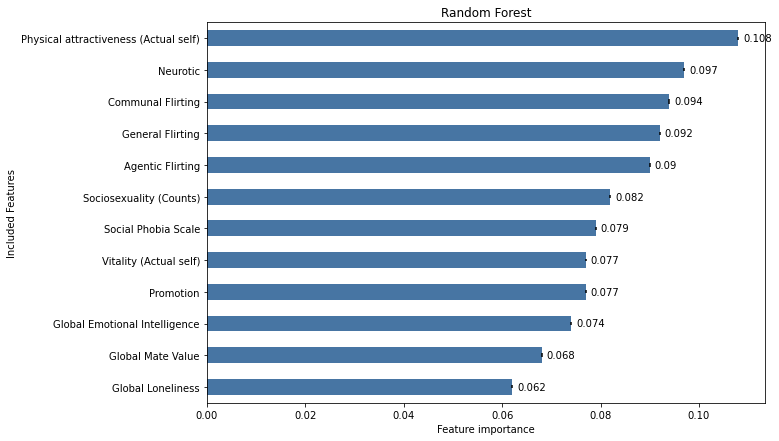

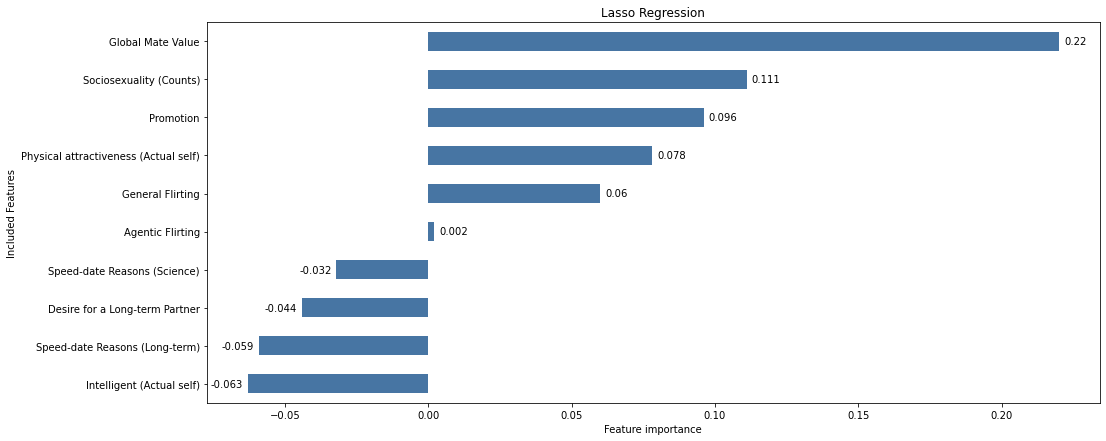

In [38]:
# Top Features for the significantly better regressor

if p_value[1] < 0.05:
    std = np.std([tree.feature_importances_ for tree in rf_fl.best_estimator_], axis = 0)
    fig, ax = plt.subplots(figsize = (8, 7))
    fig_rf = forest_importances_in.plot.barh(yerr = std, color = (0.2, 0.4, 0.6, 0.9))
    fig_rf.set_ylabel("Included Features")
    fig_rf.set_xlabel("Feature importance")
    fig_rf.title.set_text("Random Forest")
    fig_rf.bar_label(fig_rf.containers[1], padding = 5)
    fig_rf.figure.savefig("../plots/RF.png", dpi = 400)
        
        
# if both models aren't significantly different in their performance:

else:   
    std = np.std([tree.feature_importances_ for tree in rf_fl.best_estimator_], axis = 0)
    fig, ax = plt.subplots(figsize = (10, 7))
    fig_rf = forest_importances_in.plot.barh(yerr = std, color = (0.2, 0.4, 0.6, 0.9))
    fig_rf.set_ylabel("Included Features")
    fig_rf.set_xlabel("Feature importance")
    fig_rf.title.set_text("Random Forest")
    fig_rf.bar_label(fig_rf.containers[1], padding = 5)
    fig_rf.figure.savefig("../plots/RF.png", dpi = 400, bbox_inches = "tight")
    
    fig, ax = plt.subplots(figsize = (16, 7))
    lasso_Series.plot.barh(ax = ax, color = (0.2, 0.4, 0.6, 0.9))
    ax.set_ylabel("Included Features")
    ax.set_xlabel("Feature importance")
    ax.title.set_text("Lasso Regression")
    ax.bar_label(ax.containers[0], padding = 5)
    fig.savefig("../plots/Lasso.png", dpi = 400, bbox_inches = "tight")